In [56]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from scipy import io as sio
from tensorflow.python.framework import ops
from dfs2 import DeepFeatureSelectionNew
import numpy as np
from sklearn.datasets import make_classification

iris = datasets.load_iris()
inputX = iris.data[:,[1,2,3]]
inputY = iris.target

# digits = datasets.load_digits()
# inputX = digits.data  
# inputY = digits.target

# inputX, inputY = make_classification(n_samples=1000, n_features=7500, n_informative=3000, n_redundant=0, n_repeated=0, n_classes=2)

X_train, X_test, y_train, y_test = train_test_split(inputX, inputY, test_size=0.2, random_state=42)

In [63]:
iris['feature_names']

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [58]:
ops.reset_default_graph()

dfsMLP = DeepFeatureSelectionNew(X_train, X_test, y_train, y_test, n_input=1, hidden_dims=[5], \
                                 lambda1=0.001, lambda2=0.1, alpha1=0.01, alpha2=0.05, \
                                 weight_init='sda',epochs=2000, optimizer='FTRL', print_step=500)

dfsMLP.train(batch_size=100)

Layer 1
3
5
epoch 49: global loss = 2.02982711792
epoch 99: global loss = 1.86399841309
epoch 0: global loss = 1.16152405739
('Train accuracy:', 0.32499999)
('Test accuracy:', 0.36666667)
epoch 500: global loss = 0.373188257217
('Train accuracy:', 0.94166666)
('Test accuracy:', 0.83333331)
epoch 1000: global loss = 0.342940330505
('Train accuracy:', 0.94166666)
('Test accuracy:', 0.83333331)
epoch 1500: global loss = 0.336067378521
('Train accuracy:', 0.94166666)
('Test accuracy:', 0.83333331)
[array([ -2.70360589e+00,  -2.57519889e+00,   1.83934571e-05], dtype=float32)]
('Final test accuracy:', 0.83333331)


In [45]:
dfsMLP.selected_ws[0]

array([ 2.02792311, -2.54703355, -2.82233405,  2.54741979], dtype=float32)

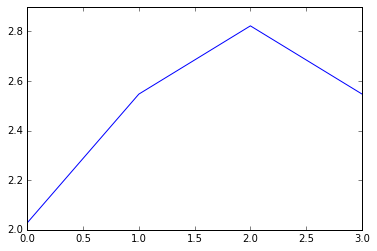

In [44]:
%matplotlib inline

import matplotlib.pyplot as plt

temp = abs(dfsMLP.selected_ws[0])

plt.plot(temp)

In [5]:
temp = dfsMLP.selected_ws

temp1, temp2 = temp[0], temp[1]

In [9]:
np.where(abs(temp1)<0.01)

(array([ 0,  1,  7,  8, 15, 16, 17, 20, 23, 24, 25, 31, 32, 36, 38, 39, 40,
        41, 47, 48, 55, 56, 57, 62, 63]),)

In [10]:
np.where(abs(temp2)<0.01)

(array([ 0,  1,  7,  8, 11, 14, 15, 16, 17, 22, 23, 24, 31, 32, 36, 38, 39,
        40, 41, 44, 47, 48, 49, 51, 55, 56, 57, 59, 63]),)

In [12]:
temp = dfsMLP.selected_ws

temp3, temp4 = temp[0], temp[1]

print(np.where(abs(temp3)<0.01))
print(np.where(abs(temp4)<0.01))

(array([ 0,  1,  6,  7,  8,  9, 15, 16, 23, 24, 30, 31, 32, 39, 40, 41, 46,
       47, 48, 49, 55, 56, 57, 63]),)
(array([ 0,  1,  7,  8,  9, 12, 15, 16, 22, 23, 24, 30, 31, 32, 34, 38, 39,
       40, 41, 46, 47, 48, 49, 55, 56, 57, 63]),)


In [14]:
temp = dfsMLP.selected_ws

temp5, temp6 = temp[0], temp[1]

print(np.where(abs(temp5)<0.01))
print(np.where(abs(temp6)<0.01))

(array([ 0,  1,  6,  7,  8,  9, 10, 15, 16, 18, 23, 24, 25, 28, 30, 31, 32,
       33, 35, 36, 39, 40, 41, 44, 45, 46, 47, 48, 49, 51, 55, 56, 57, 60,
       61, 63]),)
(array([ 0,  1,  6,  7,  8,  9, 10, 15, 16, 18, 23, 24, 25, 28, 30, 31, 32,
       33, 35, 36, 39, 40, 41, 44, 45, 46, 47, 48, 49, 51, 55, 56, 57, 60,
       61, 63]),)


In [19]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils

[  0.00000000e+00   2.21365553e-05   5.34770846e-01  -5.10749221e-01
  -1.32572937e+00   1.27882481e+00   7.05722868e-01  -3.37187976e-06
  -2.48715769e-05  -4.35945988e-01  -8.12338829e-01  -1.30112066e-05
  -8.32192004e-01   2.47985512e-01   6.64107978e-01   8.89979037e-06
   2.98485284e-05  -7.03907609e-01  -5.47703326e-01  -6.97154284e-01
  -1.11955297e+00   1.22180629e+00   5.59003353e-01  -1.67842809e-05
   1.95304256e-05  -7.41886795e-02  -9.46987391e-01  -7.40651965e-01
   5.96208036e-01  -3.10005844e-01  -1.34162486e+00   3.13480268e-05
   0.00000000e+00   5.93466498e-02   6.60471499e-01   5.83744705e-01
  -9.14963067e-01  -6.60474718e-01   7.55860955e-02   0.00000000e+00
   6.03450007e-06   9.52876508e-01   1.23723471e+00  -1.11648464e+00
  -8.45939457e-01   5.80304325e-01  -5.43568313e-01   3.76154094e-06
  -2.55056784e-06  -4.34423208e-01   4.08470452e-01  -6.84513330e-01
   1.02012360e+00   7.31285095e-01  -1.04048955e+00  -9.47060198e-06
  -3.13354903e-05  -2.99332623e-06